In [9]:
#Loại bỏ những đơn hàng return
import pandas as pd
import datetime as dt
df_orders= pd.read_excel('Dataset.xlsx')
df_return = pd.read_excel('Dataset.xlsx', 'Return')
df =pd.merge(df_orders, df_return, on= "Order ID", how="outer")
df = df[df['Returned'] != "Yes"][['Customer ID','Order ID','Order Date','Sales']]
print(df)


     Customer ID        Order ID Order Date    Sales
0       CC-12430  CA-2017-126221 2017-12-30  209.300
1       PO-18865  CA-2017-143259 2017-12-30  323.136
2       PO-18865  CA-2017-143259 2017-12-30   90.930
3       PO-18865  CA-2017-143259 2017-12-30   52.776
6       JM-15580  CA-2017-156720 2017-12-30    3.024
...          ...             ...        ...      ...
9989    MB-18085  CA-2014-141817 2014-01-05   19.536
9990    PO-19195  CA-2014-112326 2014-01-04   11.784
9991    PO-19195  CA-2014-112326 2014-01-04  272.736
9992    PO-19195  CA-2014-112326 2014-01-04    3.540
9993    DP-13000  CA-2014-103800 2014-01-03   16.448

[9194 rows x 4 columns]


In [ ]:
#R
pd.to_datetime(df['Order Date'])
df['Order Date'] = pd.to_datetime(df['Order Date'])

df_recency = df.groupby(by='Customer ID', as_index=False)['Order Date'].max()
df_recency.columns = ['Customer ID', 'LastPurchaseDate']
recent_date= dt.datetime(2017,12,31)
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
print(df_recency)

In [10]:
#F
frequency_df = df.groupby(['Customer ID'], as_index=False)['Order Date'].count()
frequency_df.columns = ['Customer ID', 'Frequency']
print(frequency_df)

    Customer ID  Frequency
0      AA-10315         11
1      AA-10375         15
2      AA-10480         12
3      AA-10645         17
4      AB-10015          6
..          ...        ...
786    XP-21865         25
787    YC-21895          7
788    YS-21880         12
789    ZC-21910         27
790    ZD-21925          6

[791 rows x 2 columns]


In [11]:
#M
monetary_df = df.groupby('Customer ID', as_index=False)['Sales'].sum()
monetary_df.columns = ['Customer ID', 'Monetary']
print(monetary_df)

    Customer ID  Monetary
0      AA-10315  5563.560
1      AA-10375  1056.390
2      AA-10480  1790.512
3      AA-10645  5073.975
4      AB-10015   886.156
..          ...       ...
786    XP-21865  2110.726
787    YC-21895  5438.650
788    YS-21880  6720.444
789    ZC-21910  7892.998
790    ZD-21925  1249.184

[791 rows x 2 columns]


In [12]:
#R F M
RF = df_recency.merge(frequency_df, on='Customer ID')
df = RF.merge(monetary_df, on='Customer ID').drop(columns='LastPurchaseDate')
print(df)

    Customer ID  Recency  Frequency  Monetary
0      AA-10315      185         11  5563.560
1      AA-10375       20         15  1056.390
2      AA-10480      260         12  1790.512
3      AA-10645      483         17  5073.975
4      AB-10015      416          6   886.156
..          ...      ...        ...       ...
786    XP-21865       83         25  2110.726
787    YC-21895        5          7  5438.650
788    YS-21880       10         12  6720.444
789    ZC-21910       55         27  7892.998
790    ZD-21925      203          6  1249.184

[791 rows x 4 columns]


In [4]:
#rank của R F M
df['R_rank'] = pd.qcut(df['Recency'], q=5, labels=False) + 1
df['R_quantile'] = 6 - df['R_rank']
df['F_quantile'] = pd.qcut(df['Frequency'], q=5, labels=False) + 1
df['M_quantile'] = pd.qcut(df['Monetary'], q=5, labels=False) + 1
df['RFM score'] = df['R_quantile'] * 100 + df['F_quantile'] * 10 + df['M_quantile']
print(df[['Customer ID','R_quantile','F_quantile','M_quantile', 'RFM score']])


    Customer ID  R_quantile  F_quantile  M_quantile  RFM score
0      AA-10315           2           3           5        235
1      AA-10375           5           4           2        542
2      AA-10480           2           3           3        233
3      AA-10645           1           5           5        155
4      AB-10015           1           1           2        112
..          ...         ...         ...         ...        ...
786    XP-21865           3           5           3        353
787    YC-21895           5           1           5        515
788    YS-21880           5           3           5        535
789    ZC-21910           4           5           5        455
790    ZD-21925           2           1           2        212

[791 rows x 5 columns]


In [5]:
#Phân loại khách hàng
Segment_df= pd.read_excel('Dataset.xlsx', sheet_name='Sheet2')

def mapping(row):
    index=0
    for rs in Segment_df['RFM Score']:
        if str(row['RFM score']) in rs:
            return Segment_df['Segment'][index]
        index+=1
    return 'null'
df['segment'] = df.apply(mapping,axis=1)

print(df[['Customer ID', 'RFM score','segment']])

    Customer ID  RFM score                segment
0      AA-10315        235                At Risk
1      AA-10375        542     Potential Loyalist
2      AA-10480        233  Hibernating customers
3      AA-10645        155       Cannot Lose Them
4      AB-10015        112         Lost customers
..          ...        ...                    ...
786    XP-21865        353     Potential Loyalist
787    YC-21895        515              Promising
788    YS-21880        535         Need Attention
789    ZC-21910        455              Champions
790    ZD-21925        212  Hibernating customers

[791 rows x 3 columns]


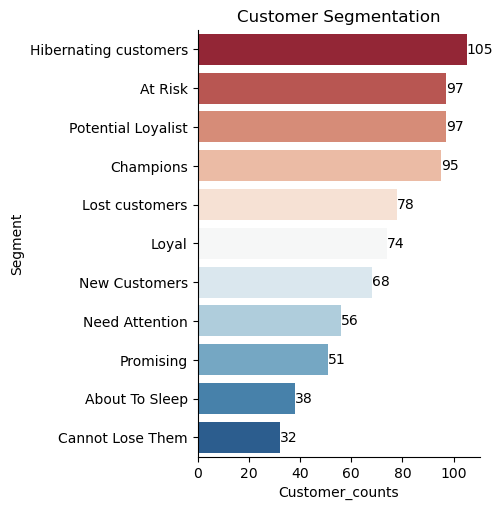

In [6]:
#Phân tích hiện trạng của công ty và đưa ra gợi ý cho team Marketing

segment_RFM = df.loc[:, ['Customer ID', 'RFM score','segment']]

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

segment_RFM['customer_counts'] = segment_RFM.groupby('segment')['Customer ID'].transform('count')

order_counts = segment_RFM.groupby('segment')['customer_counts'].sum().sort_values(ascending=False).index

chart_segment = sns.catplot(x='customer_counts', y='segment', kind='bar', palette='RdBu',order=order_counts, data=segment_RFM)
chart_segment.set(xlabel='Customer_counts', ylabel='Segment', title='Customer Segmentation')


ax = chart_segment.facet_axis(0, 0)
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

plt.show()


In [ ]:
'''Phân tích hiện trạng của công ty và đưa ra gợi ý cho team Marketing

Dựa trên phân tích từ bảng segment, phần lớn khách hàng của doanh nghiệp thuộc vào các nhóm At risk, Hibernating 
customers, Potential Loyalist, New Customers và có nhóm khách hàng Lost customers, Cannot Lose Them, About To Sleep là ít nhất. 
Điều này có thể cho thấy rằng doanh nghiệp đang gặp khó khăn trong  việc giữ chân và duy trì mối quan hệ với khách hàng hiện 
tại, có nguy cơ mất khách hàng quan trọng. Đồng thời cũng gặp khó khăn trong việc thu hút và tạo ra các khách hàng mới.

===> đây là một tình hình khá bất lợi đối với doanh nghiệp. Cần cải thiện mối quan hệ với khách hàng hiện tại như nhóm khách 
hàng At risk và Hibernating customers, đồng thời cần tập trung vào việc thu hút và tạo ra các khách hàng mới để phát triển 
doanh nghiệp.

===> Để tri ân khách hàng đã ủng hộ công ty và khai thác khách hàng có tiềm năng trở thành khách hàng trung thành, phòng 
Marketing có thể áp dụng một số gợi ý sau:

1. Khuyến mãi đặc biệt dành cho khách hàng trung thành và khách hàng mới:
- Tặng quà/ tặng phiếu mua hàng cho khách hàng mua hàng trên mức giá nhất định trong thời gian giới hạn.
- Giảm giá cho khách hàng đăng ký thành viên mới hoặc mua hàng lần đầu tiên.
2. Tặng quà miễn phí hoặc giảm giá sản phẩm cho các khách hàng tham gia khảo sát hoặc đánh giá sản phẩm giúp khuyến khích khách
hàng tham gia khảo sát để đánh giá sản phẩm và dịch vụ của công ty.
3. Chương trình khuyến mãi mùa giáng sinh và năm mới:
- Tạo ra các gói quà tặng giá trị cho khách hàng mua hàng trong mùa giáng sinh và năm mới.
- Khuyến khích khách hàng chia sẻ trên mạng xã hội hoặc đăng ký nhận tin tức của công ty để được nhận những thông tin về chương 
trình này.
4. Tăng cường việc tiếp cận khách hàng trên các nền tảng kỹ thuật số:
- Tăng cường việc quảng cáo trên các mạng xã hội như Facebook, Instagram, Twitter, Tiktok, ...
- Gửi email thông báo khuyến mãi đến khách hàng.
Tăng cường hoạt động trên website và app của công ty để thu hút khách hàng truy cập.
5. Tạo ra chương trình giới thiệu khách hàng mới:
- Khuyến khích khách hàng hiện tại giới thiệu bạn bè, người thân đến mua hàng tại công ty.
- Tặng quà miễn phí hoặc giảm giá sản phẩm cho khách hàng giới thiệu được người khác đến mua hàng.'''


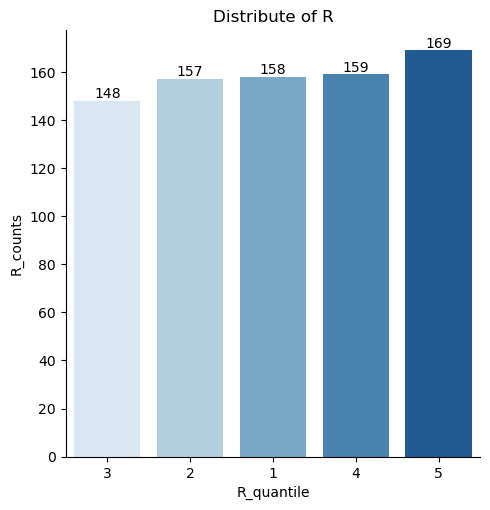

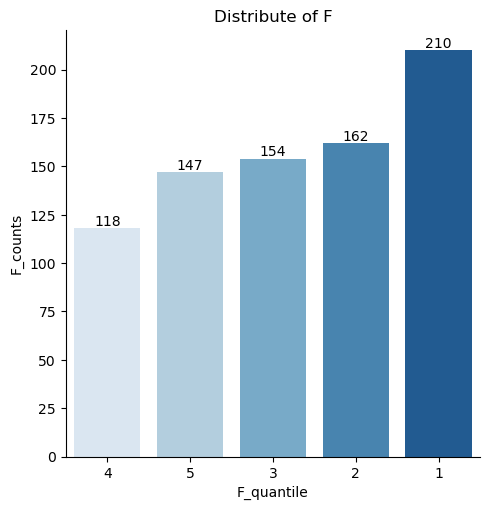

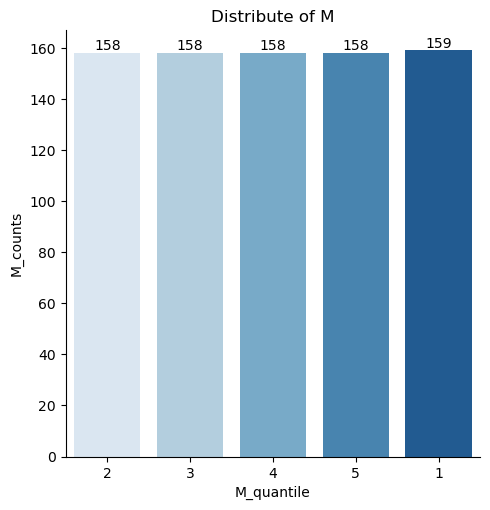

In [7]:
# Gợi ý với team Marketing và Sales với mô hình bán lẻ của công ty Superstore thì nên quan tâm nhất vào chỉ số nào trong 3 chỉ số R, F, M

df['R_counts'] = df.groupby('R_quantile')['Customer ID'].transform('count')
order_R_counts = df.groupby('R_quantile')['R_counts'].sum().sort_values(ascending=True).index
g1 = sns.catplot(x='R_quantile', y='R_counts', kind='bar',palette='Blues',order=order_R_counts, data=df)
plt.title('Distribute of R')

# ax1 = g1.facet_axis(0, 0)
    
# for c in ax1.containers:
#     ax1.bar_label(c, label_type='edge')
    
# plt.show()

df['F_counts'] = df.groupby('F_quantile')['Customer ID'].transform('count')
order_F_counts = df.groupby('F_quantile')['F_counts'].sum().sort_values(ascending=True).index
g2 = sns.catplot(x='F_quantile', y='F_counts', kind='bar',palette='Blues',order=order_F_counts, data=df)
plt.title('Distribute of F')

# ax2 = g2.facet_axis(0, 0)
# for c in ax2.containers:
#     ax2.bar_label(c, label_type='edge')
    
# plt.show()

df['M_counts'] = df.groupby('M_quantile')['Customer ID'].transform('count')
order_M_counts = df.groupby('M_quantile')['M_counts'].sum().sort_values(ascending=True).index
g3 = sns.catplot(x='M_quantile', y='M_counts', kind='bar',palette='Blues',order=order_M_counts, data=df)
plt.title('Distribute of M')

# ax3 = g3.facet_axis(0, 0)
# for c in ax3.containers:
#     ax3.bar_label(c, label_type='edge')

for g in [g1,g2,g3]:
    ax = g.facet_axis(0, 0)
    
    for c in ax.containers:
        ax.bar_label(c, label_type='edge')
    
plt.show()


In [ ]:
'''Gợi ý với team Marketing và Sales với mô hình bán lẻ của công ty Superstore thì nên quan tâm nhất vào chỉ số nào trong 3 
chỉ số R, F, M?

    Biến F có độ đo dao động nhiều hơn so với biến R và M, có thể cho thấy sự khác biệt về hoạt động mua hàng của các khách 
hàng trong đó. Tuy nhiên, biến R và M gần như không dao động, có thể cho thấy sự ổn định trong quá trình mua sắm và
chi tiêu của khách hàng. 
   Mục đích của công ty là giữ chân khách hàng hiện tại và tìm kiếm thêm khách hàng mới, thì công ty nên quan tâm đến tất cả 
ba chỉ số RFM. Tuy nhiên, để tìm kiếm khách hàng mới, một trong những chỉ số quan trọng nhất cần quan tâm là Frequency để 
xác định khách hàng nào đã mua hàng nhiều lần và có thể trở thành khách hàng trung thành trong tương lai.

===> Quan tâm đến chỉ số Frequency nhất có thể cân nhắc các chiến lược sau:

1. Tạo chương trình thưởng khách hàng thân thiết: khách hàng sẽ được khuyến khích mua hàng thường xuyên hơn
2. Phát triển chương trình khách hàng mới: Tạo ra chương trình khuyến mãi hấp dẫn để thu hút khách hàng mới: có thể bao gồm
ưu đãi đặc biệt hoặc giảm giá đối với khách hàng mới. 
3. Cải thiện trải nghiệm khách hàng
4. Tăng tần suất gửi email marketing: Tăng tần suất gửi email marketing với chương trình khuyến mãi hấp dẫn đối với khách
hàng thân thiết hoặc khách hàng mới có thể tăng cơ hội tăng Frequency của khách hàng.
5. Xác định các sản phẩm được ưa chuộng: Nghiên cứu khách hàng để tìm ra những sản phẩm và dịch vụ nào được ưa chuộng nhất.
Sau đó, đưa ra các chiến lược khuyến mãi đặc biệt cho các sản phẩm này để khuyến khích khách hàng mua hàng thường xuyên 
hơn.'''